In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.pipeline import Pipeline

from swimnetworks import (Dense, Linear)

In [2]:
def tanh_x(x):
    """First derivative of tanh.
    """
    x = np.clip(x, -10, 10)
    return 1/np.cosh(x)**2

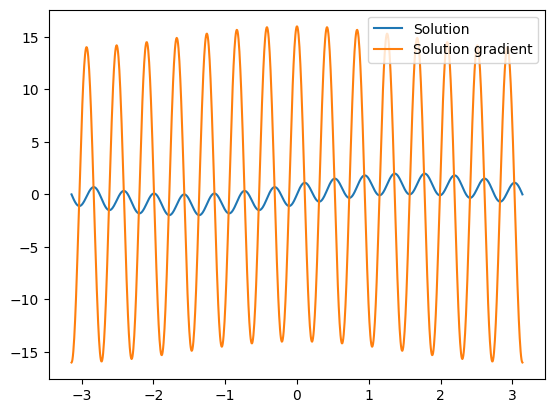

In [3]:
# setup the problem ODE
def u_true(x):
    return np.sin(x) + np.sin(15*x)
def u_true_grad(x):
    return np.cos(x) + 15*np.cos(15*x)

x_plot = np.linspace(-np.pi, np.pi, 1000).reshape((-1, 1))

fig, ax = plt.subplots(1, 1)
ax.plot(x_plot, u_true(x_plot), label='Solution')
ax.plot(x_plot, u_true_grad(x_plot), label='Solution gradient')
ax.legend()

(1002, 22) (1002, 1)
(1002, 66) (1002, 1)
(1002, 112) (1002, 1)
(1002, 156) (1002, 1)
(1002, 202) (1002, 1)
time for solving and plotting: 0.0751485824584961 seconds.


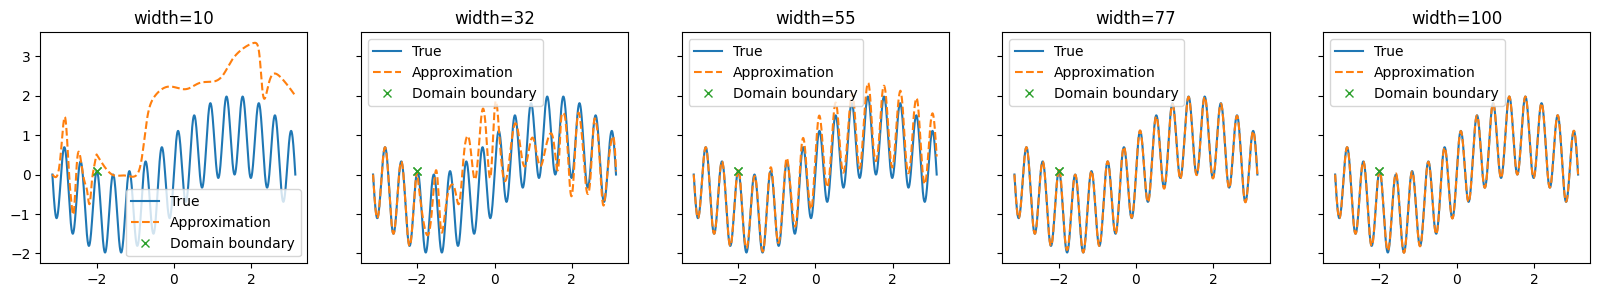

In [5]:
activation = np.tanh
activation_x = tanh_x

def solve_swim_PINN(x_inner, x_boundary, u_true_grad_inner, u_true_boundary, x_boundary_inner, layer_width, random_state=1):
    """Construct a list of PINNs that solve a simple ode over a decomposed domain.
    The ode to solve is $u_x=f(u(x))$, for $x$ in the 1D domain."""
    # construct good basis functions by sampling activation functions based on the known data
    # we must run over all domains and create models for each
    def fit_model(x_part_idx, x_boundary_part, x_shared_part):
        model_ansatz = Pipeline([
            ("hidden", Dense(
                layer_width=layer_width,
                activation=activation,
                parameter_sampler='tanh',
                random_seed=random_state)),
            ("linear", Linear(regularization_scale=1e-10))]
        )
        model_ansatz.fit(x_inner[x_part_idx], u_true_grad_inner[x_part_idx])

        hidden_layer = model_ansatz.steps[0][1]

        # setup the linear system to solve for the outer coefficietns

        # first, evaluate the gradient of the ansatz function
        hidden_layer.activation = activation_x
        u_gradient = hidden_layer.predict(x_inner[x_part_idx]) * hidden_layer.weights

        # evaluate it on the boundary as well
        hidden_layer.activation = activation
        u_boundary = hidden_layer.predict(x_boundary_part)
        u_shared = hidden_layer.predict(x_shared_part)
        return model_ansatz, u_gradient, u_boundary, u_shared

    left_data = fit_model(np.arange(0, x_inner.shape[0]//2), x_boundary_part=np.row_stack([x_boundary[0]]), x_shared_part=x_boundary_inner)
    right_data = fit_model(np.arange(x_inner.shape[0]//2, x_inner.shape[0]), x_boundary_part=np.row_stack([x_boundary[1]]), x_shared_part=x_boundary_inner)

    # setup the linear system inputs and outputs
    # also add the bias term
    matrix_in = np.row_stack([
        np.column_stack([left_data[1], np.zeros(left_data[1].shape[0]), 0*right_data[1], 0*np.zeros(right_data[1].shape[0])]),    # gradient
        np.column_stack([0*left_data[1], np.zeros(left_data[1].shape[0]), right_data[1], np.zeros(right_data[1].shape[0])]),    # gradient
        np.column_stack([left_data[2], np.ones(left_data[2].shape[0]), 0*right_data[2], np.zeros(right_data[2].shape[0])]),   # boundary left
        #np.column_stack([0*left_data[2], np.zeros(left_data[2].shape[0]), right_data[2], np.ones(right_data[2].shape[0])]),   # boundary right
        np.column_stack([left_data[3], np.ones(left_data[3].shape[0]), -right_data[3], -np.ones(right_data[3].shape[0])]),     # shared boundary
    ])

    # construct the output matrix
    matrix_out = np.row_stack([
        u_true_grad_inner,
        u_true_boundary[:1],
        np.zeros((x_boundary_inner.shape[0],))
    ])

    # solve
    print(matrix_in.shape, matrix_out.shape)
    c = np.linalg.lstsq(matrix_in, matrix_out, rcond=1e-10)[0]
    c_left, c_right = c[:len(c)//2], c[len(c)//2:]

    left_data[0].steps[1][1].weights = c_left[:-1]
    left_data[0].steps[1][1].biases = c_left[-1]
    right_data[0].steps[1][1].weights = c_right[:-1]
    right_data[0].steps[1][1].biases = c_right[-1]

    def combined_model(x):
        left_pred = left_data[0].predict(x) * (x < x_boundary_inner)
        right_pred = right_data[0].predict(x) * (x >= x_boundary_inner)
        return left_pred + right_pred

    return combined_model

random_state = 1
n_pts_train = 1000
xlim = [-np.pi, np.pi]
rng = np.random.default_rng(random_state)
x_boundary = np.array(xlim).reshape((-1, 1))
x_boundary_inner = np.array([-2]).reshape((-1, 1))
x_train = np.sort(rng.uniform(xlim[0], x_boundary_inner[0], size=(n_pts_train//2, 1)), axis=0)
x_train = np.row_stack([x_train, np.sort(rng.uniform(x_boundary_inner[0], xlim[1], size=(n_pts_train//2, 1)), axis=0)])
u_grad_train = u_true_grad(x_train)
u_boundary_train = u_true(x_boundary)

layer_widths = np.linspace(10, 100, 5).astype(int)
fig, ax = plt.subplots(1, len(layer_widths), figsize=(20, 3), sharey=True)

t0 = time()
for k in range(len(ax)):
    model = solve_swim_PINN(
        x_inner=x_train,
        x_boundary=x_boundary,
        u_true_grad_inner=u_grad_train,
        u_true_boundary=u_boundary_train,
        x_boundary_inner=x_boundary_inner,
        layer_width=int(layer_widths[k]),
        random_state=1)

    ax[k].plot(x_plot, u_true(x_plot), '-', label='True')
    ax[k].plot(x_plot, model(x_plot), '--', label='Approximation')
    ax[k].plot([x_boundary_inner[0], x_boundary_inner[0]], [u_true(x_boundary_inner[0]), u_true(x_boundary_inner[0])], 'x', label='Domain boundary')
    ax[k].set_title(f'width={layer_widths[k]}')
    ax[k].legend()

print("time for solving and plotting:", time()-t0, "seconds.")